<hr style="border:0.2px solid black"> </hr>

<figure>
  <IMG SRC="img/ntnu_logo.png" WIDTH=200 ALIGN="right">
</figure>

**<ins>Course:</ins>** TVM4174 - Hydroinformatics for Smart Water Systems

# <ins>Solution to Assignment 1:</ins> Hydraulic network calibration
    
*Developed by David Steffelbauer*

    
<hr style="border:0.2px solid black"> </hr>

## Task 0: Import all relevant packages 
*(0 points)*

In [2]:
# Import all packages that you use later on in this cell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
import seaborn as sns
from scipy.optimize import minimize, differential_evolution
from functools import partial
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

## Task 1: Plot the measurement data and the network model 
*(5 points)*

* Load the measurement data from `data/Measurements.csv`
* Plot the Tank level measurement in a line plot for all scenarios in a Figure
* Plot the pressure measurements for each sensor as a line over the different scenarios in one Figure
* Plot the hydrant outflows as a barplot. The scenarios should be the x-axis, the outflow on the y-axis, and each hydrant should have its own bar per scenario.
* Load the EPANET model `data/Exercise.inp` into `wntr` and plot the model. Color the links according to the diameters, the nodes according to the elevation, add the tank as a diamond and a text label for the tank, plus the locations of the opened hydrants as crosses and the locations of the pressure sensors as circles

*Remember to add titles, legends, axis labels, set axis limits for each plot; otherwise, you will not get all points. This is also true for the following tasks!*


In [3]:
# Solution Task 1.a) Load the measurement data from data/Measurements.csv

# Read data 
data = pd.read_csv('data/Measurements.csv', index_col=0)
data

,S0,S1,S6,S7,S8,S11,S12,S14
Sensors,,,,,,,,
HG3420,83.97,74.57,76.14,74.55,80.82,73.19,76.99,78.65
HG3445,69.86,60.43,62.05,60.43,66.70,59.08,62.89,64.54
HG3835,89.36,73.70,82.43,78.81,84.67,75.72,82.10,84.49
HG3933,91.21,71.25,84.28,79.63,85.66,77.59,83.93,86.33
HG4150,76.68,67.21,45.76,58.18,73.52,65.83,69.17,70.10
HG4162,87.66,78.20,68.62,73.78,84.52,76.81,80.20,81.12
HG4215,90.26,80.82,71.20,76.40,87.11,79.42,82.76,83.70
HG4339b,96.37,66.11,89.64,82.52,86.45,83.06,89.18,91.60
HG4383,90.11,60.58,83.34,76.42,80.07,76.74,82.95,85.28


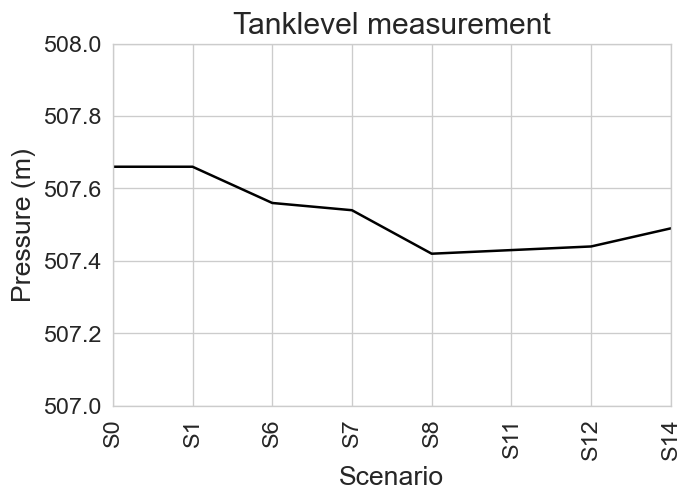

In [4]:
# Solution Task 1.b) Plot the Tank level measurement in a line plot for all scenarios in a Figure

tl = data.loc['Tanklevel']
fig, ax = plt.subplots()

ax.plot(tl.index, tl.values, 'k')
ax.set_title('Tanklevel measurement', fontsize=18)
ax.set_ylim((507, 508))
ax.set_xlim((0, len(tl)-1))
ax.set_xlabel('Scenario', fontsize=16)
ax.set_ylabel('Pressure (m)', fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14);

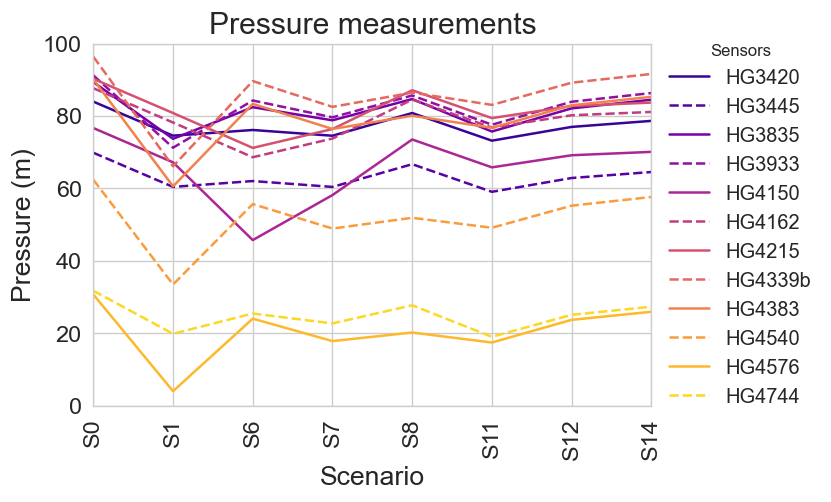

In [5]:
# Solution to Task 1.c) Plot the pressure measurements for each sensor as a line over the different scenarios in one Figure

# Plot pressures:
pressure_sensors = [x for x in data.index if x.startswith('HG')]
pressures = data.loc[pressure_sensors]

fig, ax = plt.subplots()
colors = sns.color_palette('plasma', len(pressure_sensors))
styles = ['-', '--']

for ii, (name, pressure) in enumerate(pressures.iterrows()):
    ax.plot(pressure.index, pressure.values, color=colors[ii], label=name, linestyle=styles[ii % 2])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=12, title='Sensors')
ax.set_xlabel('Scenario', fontsize=16)
ax.set_ylabel('Pressure (m)', fontsize=16)
ax.set_xlim((0, len(pressure)-1))
ax.set_ylim((0, 100))
ax.set_title('Pressure measurements', fontsize=18);
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14);

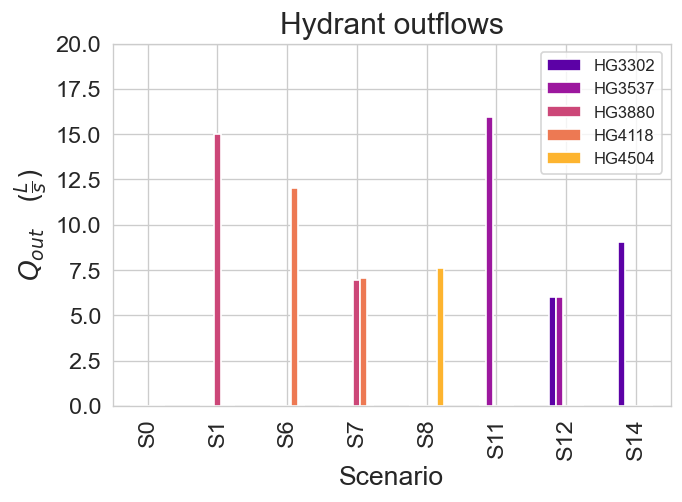

In [6]:
# Solution to Task 1.d)
hydrants = [x for x in data.index if x.startswith('Demand')]
outflows = data.loc[hydrants]

outflows.index = [x.replace('Demand_', '') for x in outflows.index]

outflows.T.plot(kind='bar', color=sns.color_palette('plasma', 5))
plt.ylim((0, 20))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.xlabel('Scenario', fontsize=16)
plt.ylabel(r'$Q_{out} \quad (\frac{L}{s})$', fontsize=16);
plt.title('Hydrant outflows', fontsize=18);

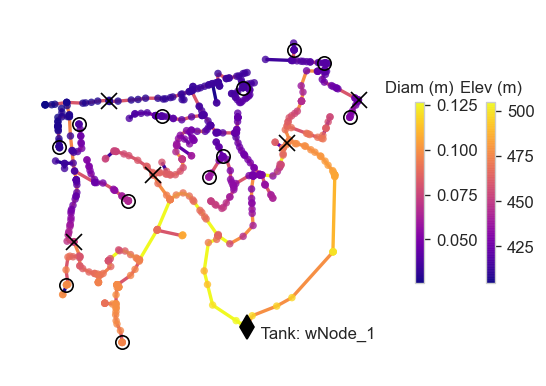

In [7]:
# Solution to Task 1.e)

cmap = plt.cm.plasma

epanet_file = 'data/Exercise.inp'

wn = wntr.network.WaterNetworkModel(epanet_file)

elevation = wn.query_node_attribute('elevation')
diameter = wn.query_link_attribute('diameter')

wntr.graphics.plot_network(wn, 
                           link_attribute=diameter, 
                           node_attribute=elevation, 
                           link_cmap=cmap, 
                           node_cmap='plasma', 
                           link_width=2, 
                           node_alpha=0.8,
                           node_colorbar_label='Elev (m)',
                           link_colorbar_label='Diam (m)'
                          );

tankname = wn.reservoir_name_list[0]
r = wn.get_node(tankname)
x, y = r.coordinates
plt.plot(x, y, 'kd', ms=10)
plt.text(x, y, f'   Tank: {tankname}', ha='left', va='top');


for hydrant in outflows.index:
    h = wn.get_node(hydrant)
    x, y = h.coordinates
    plt.plot(x, y, 'kx', ms=10)

for sensor in pressure_sensors:
    s = wn.get_node(sensor)
    x, y = s.coordinates
    plt.plot(x, y, 'ko', ms=8, markerfacecolor='None')    

## Task 2: Simulate the network and compare the results with the measurements 
*(5 points)*

* Load the measurement data from `data/Measurement.csv` and the EPANET model `data/Exercise.inp`
* Overwrite the multiplier of the tank level pattern (Pattern with the name `'2'`) with the tank level measurements. Each time step in the pattern corresponds to a scenario.
* Add a new pattern for each open hydrant, with multipliers corresponding to the scenarios (similar to the tank level pattern).
* To make an extended period simulation, change the simulation duration parameter in `wntr`. Be careful; the duration is set in seconds, but the pattern and report time steps are in hours, so change the duration to the number of scenarios multiplied by the number of seconds in an hour.
* Calculate the sum of squared errors between the measured and simulated pressures over all scenarios and sensors, and make a nice print output.
* Make a correlation plot, where the measured pressures are on the x-axis, and the corresponding simulated pressures are shown on the y-axis. Depict the scenarios in different colors, and add a black dashed line depicting the perfect correlation (45 degrees starting from (0,0))
* Depict the mean absolute difference (MAD) over the scenarios for each sensor in a `wntr` network plot ($\text{MAD}_i = \sum_{j}^{N_S} |p_{ij} - \hat{p}_{ij}|  $)

We see that the sensors in the west side of the network show more significant differences, so we assume that a valve (pipe) might be partially closed somewhere at this side of the network. A partly closed valve can be simulated with a high minor loss coefficient. We can search for this valve by "calibrating" for it.

In [8]:
# Task 2.a) Load the measurement data from data/Measurement.csv and the EPANET model data/Exercise.inp

# Measurement data is already loaded previously 
epanet_file = 'data/Exercise.inp'

wn = wntr.network.WaterNetworkModel(epanet_file)

# Task 2.b) Overwrite the multiplier of the tank level pattern 
p2 = wn.get_pattern('2')
p2.multipliers = tl.values


# Task 2.c) Add a new pattern for each open hydrant
for name, row in outflows.iterrows():
    hydrant = name
    wn.add_pattern(name=name, pattern=row.values)
    h = wn.get_node(hydrant)
    h.add_demand(base=1 / 1000, pattern_name=name)
    
# Task 2.d) make an extended period simulation
wn.options.time.duration = 3600 * 7

In [9]:
p_measured = pressures

sim = wntr.sim.EpanetSimulator(wn)
report = sim.run_sim()
p_simulated = report.node['pressure'][pressure_sensors].T
p_simulated.index = p_measured.index
p_simulated.columns = p_measured.columns

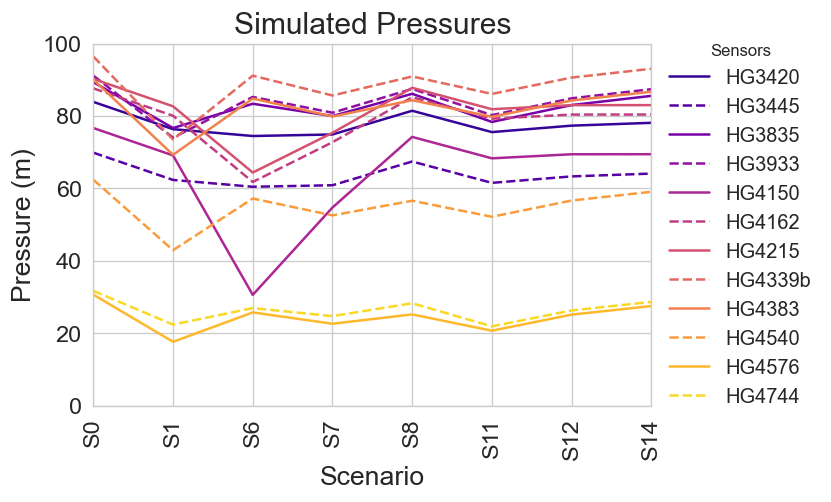

In [10]:
# Plot pressures:
pressures = p_simulated
fig, ax = plt.subplots()
colors = sns.color_palette('plasma', len(pressure_sensors))
styles = ['-', '--']

for ii, (name, pressure) in enumerate(pressures.iterrows()):
    ax.plot(pressure.index, pressure.values, color=colors[ii], label=name, linestyle=styles[ii % 2])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=12, title='Sensors')
ax.set_xlabel('Scenario', fontsize=16)
ax.set_ylabel('Pressure (m)', fontsize=16)
ax.set_xlim((0, len(pressure)-1))
ax.set_ylim((0, 100))
ax.set_title('Simulated Pressures', fontsize=18);
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14);

In [11]:
# Task 2.e) Calculate the sum of squared errors between the measured and simulated pressures

SSE = ((p_measured - p_simulated)**2).sum().sum()

print(f'The sum of squared errors is SSE = {SSE:.2f}')

The sum of squared errors is SSE = 1075.89


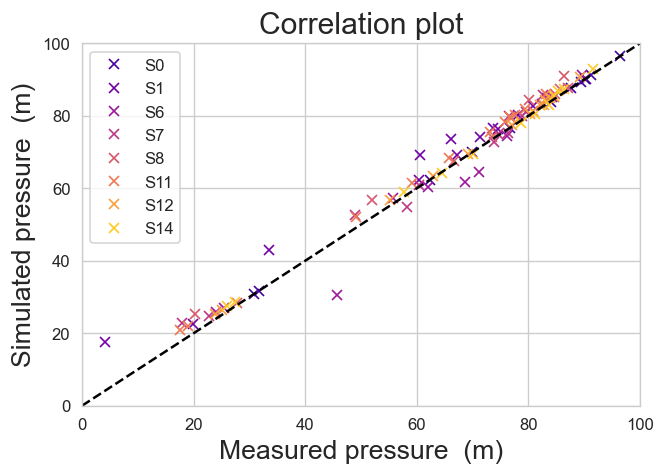

In [12]:
# Task 2.f) Make a correlation plot

colors = sns.color_palette('plasma', p_simulated.shape[1])


fig, ax = plt.subplots()

for ii, key in enumerate(p_simulated.keys()):

    x = p_measured[key].values
    y = p_simulated[key].values
    
    ax.plot(x, y, marker='x', linestyle='None', color=colors[ii], label=key)

    
plt.legend()
ax.axline([0, 0], [1, 1], color='k', linestyle='--')
ax.set_xlim((0, 100))
ax.set_ylim((0, 100));
ax.set_xlabel('Measured pressure  (m)', fontsize=16)
ax.set_ylabel('Simulated pressure  (m)', fontsize=16)
ax.set_title('Correlation plot', fontsize=18);
    

$$ SSE = \sum_{s=1}^{N_S} \sum_{n=1}^{N_p} \left( p_{s,n} - \hat{p}_{s,n} \right)^2 $$

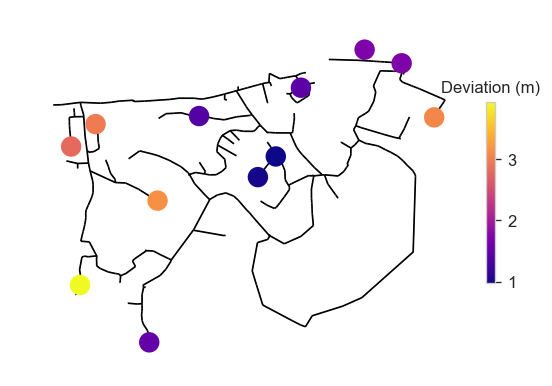

In [13]:
# Task 2.g) Depict the mean absolute difference 

deviation = (np.abs(p_measured - p_simulated)).mean(axis=1)
wntr.graphics.plot_network(wn, node_attribute=deviation, node_size=150, node_cmap='plasma', node_colorbar_label='Deviation (m)');

## Task 3: Find the partly closed valve and its corresponding minor loss
(5 points)
* Find the valve: Iterate over all pipes and within the iteration, set the minor loss for the specific pipe to 100, simulate the network, calculate the SSE with the measurements. The pipe with the lowest SSE value is the most likely (partly)  closed pipe. (Do not forget to reset the minor loss to 0.0 after the simulation)!
* Identify the actual minor loss: Write a function that sets a minor loss at the before-identified pipe and returns the SSE value. Use Powell's method with the `minimize` function in the `scipy.optimize` package to calculate the optimal minor loss coefficient. Set the boundaries between 1 and 2000.
* Simulate the network with the partly closed valve and the optimal minor loss coefficient, calculate the SSE, and make a correlation plot again. If the correlation between the measurements and the simulated pressures improved, use this model for the subsequent roughness calibration in the final task.


In [14]:
# Task 3.1) Find the valve
result = dict()
for pipe_name in wn.pipe_name_list:
    
    wn.reset_initial_values()
    sim = wntr.sim.EpanetSimulator(wn)
    pipe = wn.get_link(pipe_name)
    pipe.minor_loss = 400
    report = sim.run_sim()
    p_simulated = report.node['pressure'][pressure_sensors].T
    p_simulated.index = p_measured.index
    p_simulated.columns = p_measured.columns
    pipe.minor_loss = 0.0
    SSE = np.sum(np.sum((p_measured - p_simulated)**2))
    result[pipe_name] = SSE

result = pd.Series(result)
    

In [21]:
valve = (result - result.min())/(result.max() - result.min())
print(valve.idxmin())
valve.describe()

LHG4505d


count    658.000000
mean       0.036798
std        0.121441
min        0.000000
25%        0.011029
50%        0.011030
75%        0.011030
max        1.000000
dtype: float64

<AxesSubplot:>

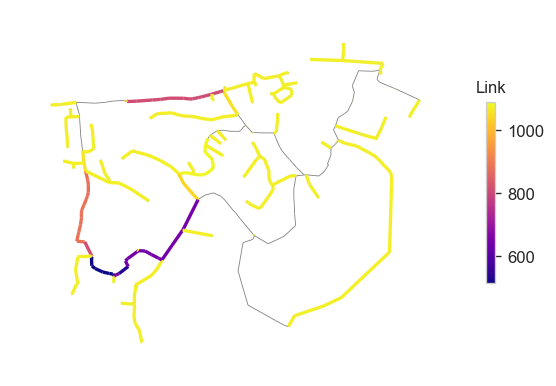

In [16]:
wntr.graphics.plot_network(wn, link_attribute=result[result<result.quantile(0.8)], node_size=0, link_cmap=plt.cm.plasma,link_width=2)

In [22]:
# Task 3.b) Identify the actual minor loss

closed_pipe = valve.idxmin()

for pipe in wn.pipe_name_list:
    
    p = wn.get_link(pipe)
    p.minor_loss = 0.0


closed_pipe = valve.idxmin()


def evaluate_minor_loss(x, wn=wn):
    
    wn.reset_initial_values()
    sim = wntr.sim.EpanetSimulator(wn)
    pipe = wn.get_link(closed_pipe)
    pipe.minor_loss = float(x)
    report = sim.run_sim()
    p_simulated = report.node['pressure'][pressure_sensors].T
    p_simulated.index = p_measured.index
    p_simulated.columns = p_measured.columns
    pipe.minor_loss = float(0.0)
    return np.sum(np.sum((p_measured - p_simulated)**2))




fitness = partial(evaluate_minor_loss, wn=wn)
# opt_res = differential_evolution(fitness, bounds=[[1, 10000]], disp=True, popsize=100, maxiter=100)
opt_res = minimize(fitness, x0=100, bounds=[[1, 10000]], method='Powell')

print(opt_res)

   direc: array([[0.001]])
     fun: 500.9689216581786
 message: 'Optimization terminated successfully.'
    nfev: 86
     nit: 2
  status: 0
 success: True
       x: array([330.435])


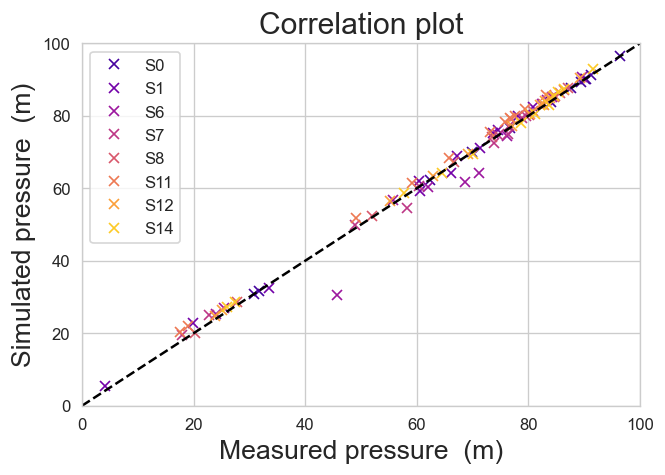

In [23]:
# Task 3.c) Simulate the network with the partly closed valve and the optimal minor loss coefficient

wn.reset_initial_values()
sim = wntr.sim.EpanetSimulator(wn)
pipe = wn.get_link(closed_pipe)
pipe.minor_loss = float(opt_res.x)
report = sim.run_sim()
p_simulated = report.node['pressure'][pressure_sensors].T
p_simulated.index = p_measured.index
p_simulated.columns = p_measured.columns

colors = sns.color_palette('plasma', p_simulated.shape[1])


fig, ax = plt.subplots()

for ii, key in enumerate(p_simulated.keys()):

    x = p_measured[key].values
    y = p_simulated[key].values
    
    ax.plot(x, y, marker='x', linestyle='None', color=colors[ii], label=key)

    
plt.legend()
ax.axline([0, 0], [1, 1], color='k', linestyle='--')
ax.set_xlim((0, 100))
ax.set_ylim((0, 100));
ax.set_xlabel('Measured pressure  (m)', fontsize=16)
ax.set_ylabel('Simulated pressure  (m)', fontsize=16)
ax.set_title('Correlation plot', fontsize=18);